## Machine Learning Model Building Pipeline: Big Data, Images and Neural Networks

In the following videos, I will take you through a practical example on how to build a Neural Network utilising a big dataset (> 1GB). In this notebook, we will do some data exploration, to understand what the dataset is about, and how we need to pre-process our data, to be able to use it in a convolutional neural network.

In the next videos, we will show you how to prepare the code for production and how to productionise your model.

We will then use the steps described here to write production code and deploy our model.

We will use the V2 Plant Seedlings Dataset available on [Kaggle.com](https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset). See below for more details.

===================================================================================================

## Differentiating weed from crop seedlings

The aim of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

### Why is this important? 

As taken from Kaggle website:

"Successful cultivation of maize depends largely on the efficacy of weed control. Weed control during the first six to eight weeks after planting is crucial, because weeds compete vigorously with the crop for nutrients and water during this period. Annual yield losses occur as a result of weed infestations in cultivated crops. Crop yield losses that are attributable to weeds vary with type of weed, type of crop, and the environmental conditions involved. Generally, depending on the level of weed control practiced yield losses can vary from 10 to 100 %. Thereore, effective weed control is imperative. In order to do effective control the first critical requirement is correct weed identification."


### What is the objective of the machine learning model?

We aim to maximise the accuracy, this is, the correct classification of the different weed varieties.

### How do I download the dataset?

To download the House Price dataset go this website:
https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset

Click on the link 'train.csv', and then click the 'download (2GB)' button towards the right of the screen, to download the dataset. Unzip the folder and rename it to 'plant_train' and save it to a directory of your choice. If you save it to the same directory from where you run this notebook, then you will be able to run the code as I do in the notebook.

**Note the following:**
-  You need to be logged in to Kaggle in order to download the datasets.
-  You may need to accept terms and conditions of the competition to download the dataset
-  If you save the file to the same directory where you saved this jupyter notebook, then you can run the code as it is written here.

**For the folder Shepherd's Purse, remove the ' so that it reads Shepherds Purse**

====================================================================================================

In [9]:
# to handle datasets
import pandas as pd
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

os.environ['KERAS_BACKEND'] = 'theano'

In [10]:
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

## Load Images / Data

In [13]:
# here are all our images
DATA_FOLDER = 'v2-plant-seedlings-dataset'

In [14]:
# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

In [15]:
# let's walk over the directory structure, so we understand
# how the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)

nt-seedlings-dataset/Charlock/254.png
v2-plant-seedlings-dataset/Charlock/268.png
v2-plant-seedlings-dataset/Charlock/37.png
v2-plant-seedlings-dataset/Charlock/23.png
v2-plant-seedlings-dataset/Charlock/136.png
v2-plant-seedlings-dataset/Charlock/122.png
v2-plant-seedlings-dataset/Charlock/452.png
v2-plant-seedlings-dataset/Charlock/334.png
v2-plant-seedlings-dataset/Charlock/320.png
v2-plant-seedlings-dataset/Charlock/446.png
v2-plant-seedlings-dataset/Charlock/308.png
v2-plant-seedlings-dataset/Charlock/442.png
v2-plant-seedlings-dataset/Charlock/324.png
v2-plant-seedlings-dataset/Charlock/330.png
v2-plant-seedlings-dataset/Charlock/318.png
v2-plant-seedlings-dataset/Charlock/126.png
v2-plant-seedlings-dataset/Charlock/132.png
v2-plant-seedlings-dataset/Charlock/27.png
v2-plant-seedlings-dataset/Charlock/33.png
v2-plant-seedlings-dataset/Charlock/250.png
v2-plant-seedlings-dataset/Charlock/244.png
v2-plant-seedlings-dataset/Charlock/278.png
v2-plant-seedlings-dataset/Charlock/293.pn

In [16]:
# let's create a dataframe:
# the dataframe stores the path to the image in one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,v2-plant-seedlings-dataset/Cleavers/348.png,Cleavers
1,v2-plant-seedlings-dataset/Cleavers/176.png,Cleavers
2,v2-plant-seedlings-dataset/Cleavers/88.png,Cleavers
3,v2-plant-seedlings-dataset/Cleavers/162.png,Cleavers
4,v2-plant-seedlings-dataset/Cleavers/189.png,Cleavers
5,v2-plant-seedlings-dataset/Cleavers/77.png,Cleavers
6,v2-plant-seedlings-dataset/Cleavers/63.png,Cleavers
7,v2-plant-seedlings-dataset/Cleavers/228.png,Cleavers
8,v2-plant-seedlings-dataset/Cleavers/200.png,Cleavers
9,v2-plant-seedlings-dataset/Cleavers/214.png,Cleavers


In [17]:
# how many images do we've got per class?
# this should give similar results to what we observed
# when we inspected the lenght of image list in the dictionary

images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [18]:
# let's isolate a path, for demo
# we want to load the image in this path later

images_df.loc[0, 'image']

'v2-plant-seedlings-dataset/Cleavers/348.png'

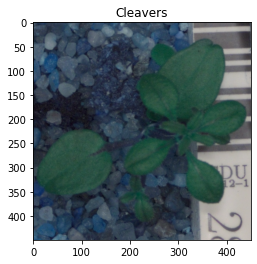

In [19]:
# let's visualise a few images
# if the images you see in your notebook are not the same, don't

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

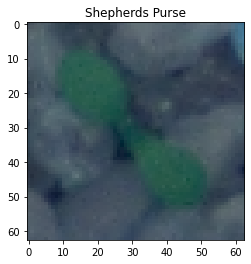

In [20]:
plot_single_image(images_df, 3000)

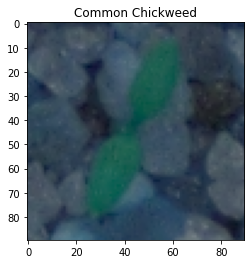

In [21]:
plot_single_image(images_df, 1000)

In [22]:
# let's go ahead and plot a bunch of our images together,
# so we get e better feeling of how our images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

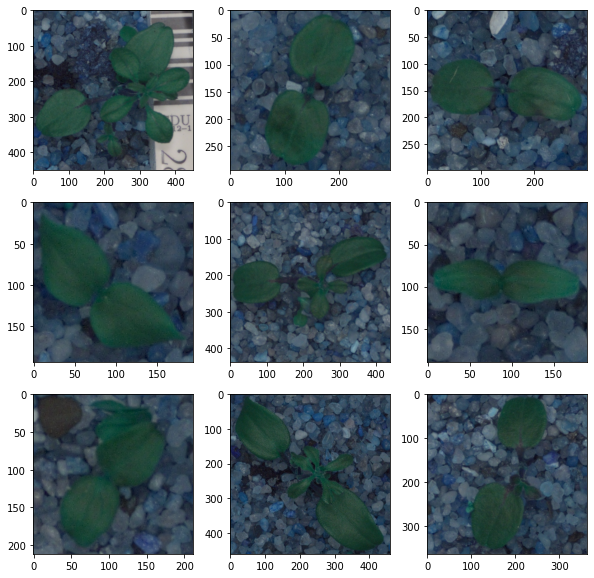

In [23]:
plot_for_class(images_df, 'Cleavers')

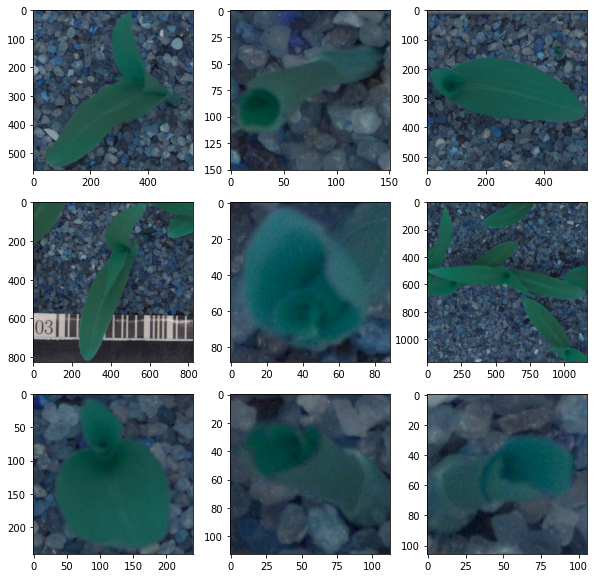

In [24]:
plot_for_class(images_df, 'Maize')

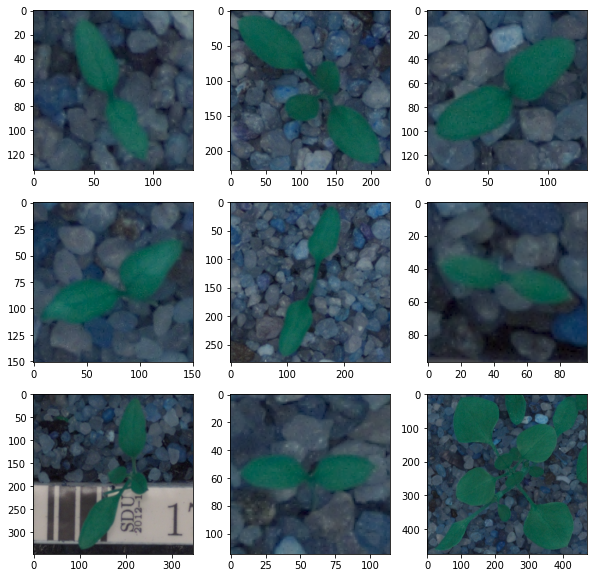

In [25]:
plot_for_class(images_df, 'Common Chickweed')

## Separate train and test

In [26]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], test_size=0.20, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [27]:
# the indeces of the training data are mixed
# this will cause problems later

X_train.head()

1922    v2-plant-seedlings-dataset/Loose Silky-bent/24...
4164       v2-plant-seedlings-dataset/Black-grass/326.png
2952    v2-plant-seedlings-dataset/Shepherds Purse/14.png
287            v2-plant-seedlings-dataset/Cleavers/93.png
4971          v2-plant-seedlings-dataset/Charlock/260.png
Name: image, dtype: object

In [28]:
# reset index, because later we iterate over row number

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    v2-plant-seedlings-dataset/Loose Silky-bent/24...
1       v2-plant-seedlings-dataset/Black-grass/326.png
2    v2-plant-seedlings-dataset/Shepherds Purse/14.png
3           v2-plant-seedlings-dataset/Cleavers/93.png
4          v2-plant-seedlings-dataset/Charlock/260.png
Name: image, dtype: object

In [29]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [30]:
# percentage of images within each class

y_train.value_counts() / len(y_train)

Loose Silky-bent             0.137666
Common Chickweed             0.128639
Scentless Mayweed            0.108328
Small-flowered Cranesbill    0.104717
Fat Hen                      0.095689
Sugar beet                   0.083277
Charlock                     0.081471
Cleavers                     0.060934
Black-grass                  0.057323
Shepherds Purse              0.048070
Common wheat                 0.047168
Maize                        0.046716
Name: target, dtype: float64

In [31]:
# should be the same in the test set

y_test.value_counts() / len(y_test)

Loose Silky-bent             0.137184
Common Chickweed             0.129061
Scentless Mayweed            0.114621
Fat Hen                      0.102888
Small-flowered Cranesbill    0.101083
Sugar beet                   0.084838
Charlock                     0.082130
Cleavers                     0.058664
Shepherds Purse              0.055054
Black-grass                  0.049639
Maize                        0.045126
Common wheat                 0.039711
Name: target, dtype: float64

In [32]:
# let's prepare the target
# it is a multiclass classification, so we need to make 
# one hot encoding of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [33]:
# The images in our folders, are all different sizes
# For neural networks however, we need images in the same size
# The images will all be resized to this size:

IMAGE_SIZE = 150

In [34]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [35]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

In [36]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes per image

def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [37]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [38]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [39]:
# number of different classes

len(y_train.unique())

12

In [40]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

# this is our cnn

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
#model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
__________

In [41]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [42]:
batch_size = 10
epochs = 8

In [36]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size, 
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/8
Epoch 00000: acc improved from -inf to 0.92092, saving model to model.h5
633s - loss: 0.2382 - acc: 0.9209
Epoch 2/8
Epoch 00001: acc improved from 0.92092 to 0.93965, saving model to model.h5
686s - loss: 0.1558 - acc: 0.9396
Epoch 3/8
Epoch 00002: acc improved from 0.93965 to 0.95018, saving model to model.h5
724s - loss: 0.1275 - acc: 0.9502
Epoch 4/8
Epoch 00003: acc improved from 0.95018 to 0.95746, saving model to model.h5
728s - loss: 0.1102 - acc: 0.9575
Epoch 5/8
Epoch 00004: acc improved from 0.95746 to 0.96581, saving model to model.h5
741s - loss: 0.0906 - acc: 0.9658
Epoch 6/8
Epoch 00005: acc improved from 0.96581 to 0.97250, saving model to model.h5
745s - loss: 0.0734 - acc: 0.9725
Epoch 7/8
Epoch 00006: acc improved from 0.97250 to 0.97873, saving model to model.h5
756s - loss: 0.0562 - acc: 0.9787
Epoch 8/8
Epoch 00007: acc improved from 0.97873 to 0.98020, saving model to model.h5
767s - loss: 0.0524 - acc: 0.9802


<Figure size 432x288 with 0 Axes>

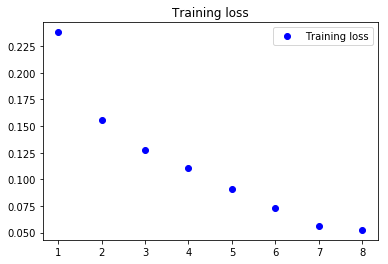

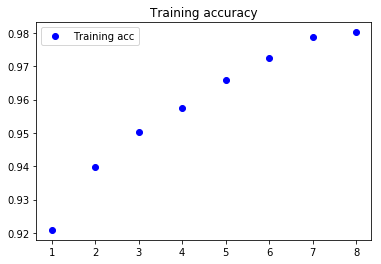

<Figure size 432x288 with 0 Axes>

In [37]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [38]:
# make a prediction

predictions = model.predict_classes(x_test, verbose=1)

1108/1108 [==============================] - 49s    


In [39]:
# inspect predictions
predictions

array([ 0,  6, 11, ...,  6,  3,  8], dtype=int64)

In [40]:
# transform target
encoder.transform(y_test)

array([ 6,  0, 11, ...,  6,  3,  3], dtype=int64)

In [41]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [42]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [43]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

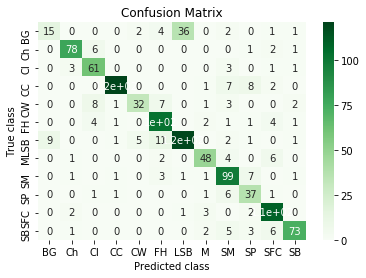

In [44]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [45]:
from sklearn.metrics import  accuracy_score


accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

0.8095667870036101

In [48]:
from sklearn.metrics import  classification_report

print(classification_report(encoder.transform(y_test), predictions))

             precision    recall  f1-score   support

          0       0.62      0.25      0.35        61
          1       0.91      0.89      0.90        88
          2       0.76      0.88      0.82        69
          3       0.96      0.87      0.91       139
          4       0.82      0.59      0.69        54
          5       0.79      0.88      0.83       117
          6       0.76      0.80      0.78       150
          7       0.81      0.79      0.80        61
          8       0.75      0.87      0.80       114
          9       0.62      0.79      0.69        47
         10       0.83      0.93      0.88       118
         11       0.90      0.81      0.85        90

avg / total       0.81      0.81      0.80      1108

